
=== CLASAMENT FINAL (Sortat dupa MAE - Eroare Absoluta) ===
MODEL        | MAE (W)    | RMSE       | TIMP (s)  
------------------------------------------------------------
XGBoost      | 53.04      | 224.04     | 6.5       s
LightGBM     | 55.45      | 223.85     | 2.3       s
GRU          | 62.49      | 310.69     | 2354.0    s
DeepAR       | 85.73      | 338.18     | 2076.3    s
RNN          | 98.27      | 349.17     | 191.7     s
LSTM         | 102.82     | 305.60     | 2215.2    s
Prophet      | 441.37     | 537.82     | 564.6     s
------------------------------------------------------------

Generare grafic timpi de antrenare...


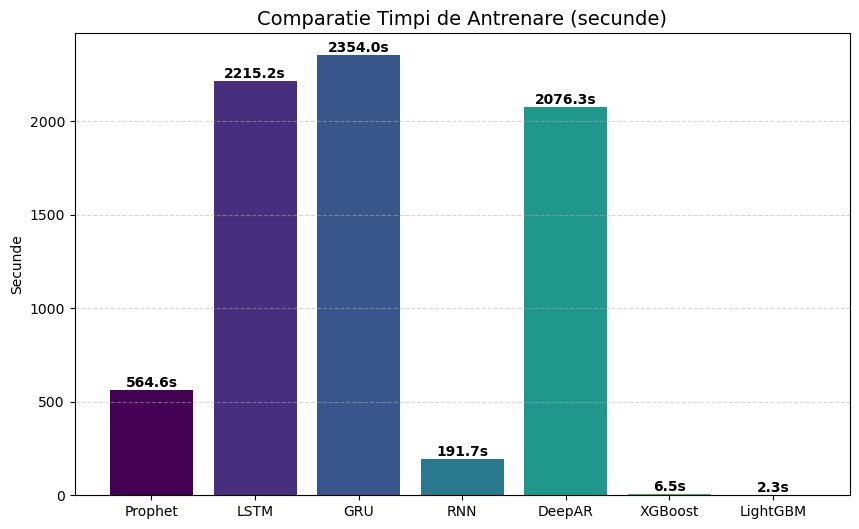


Generare grafice detaliate (Zoom)...


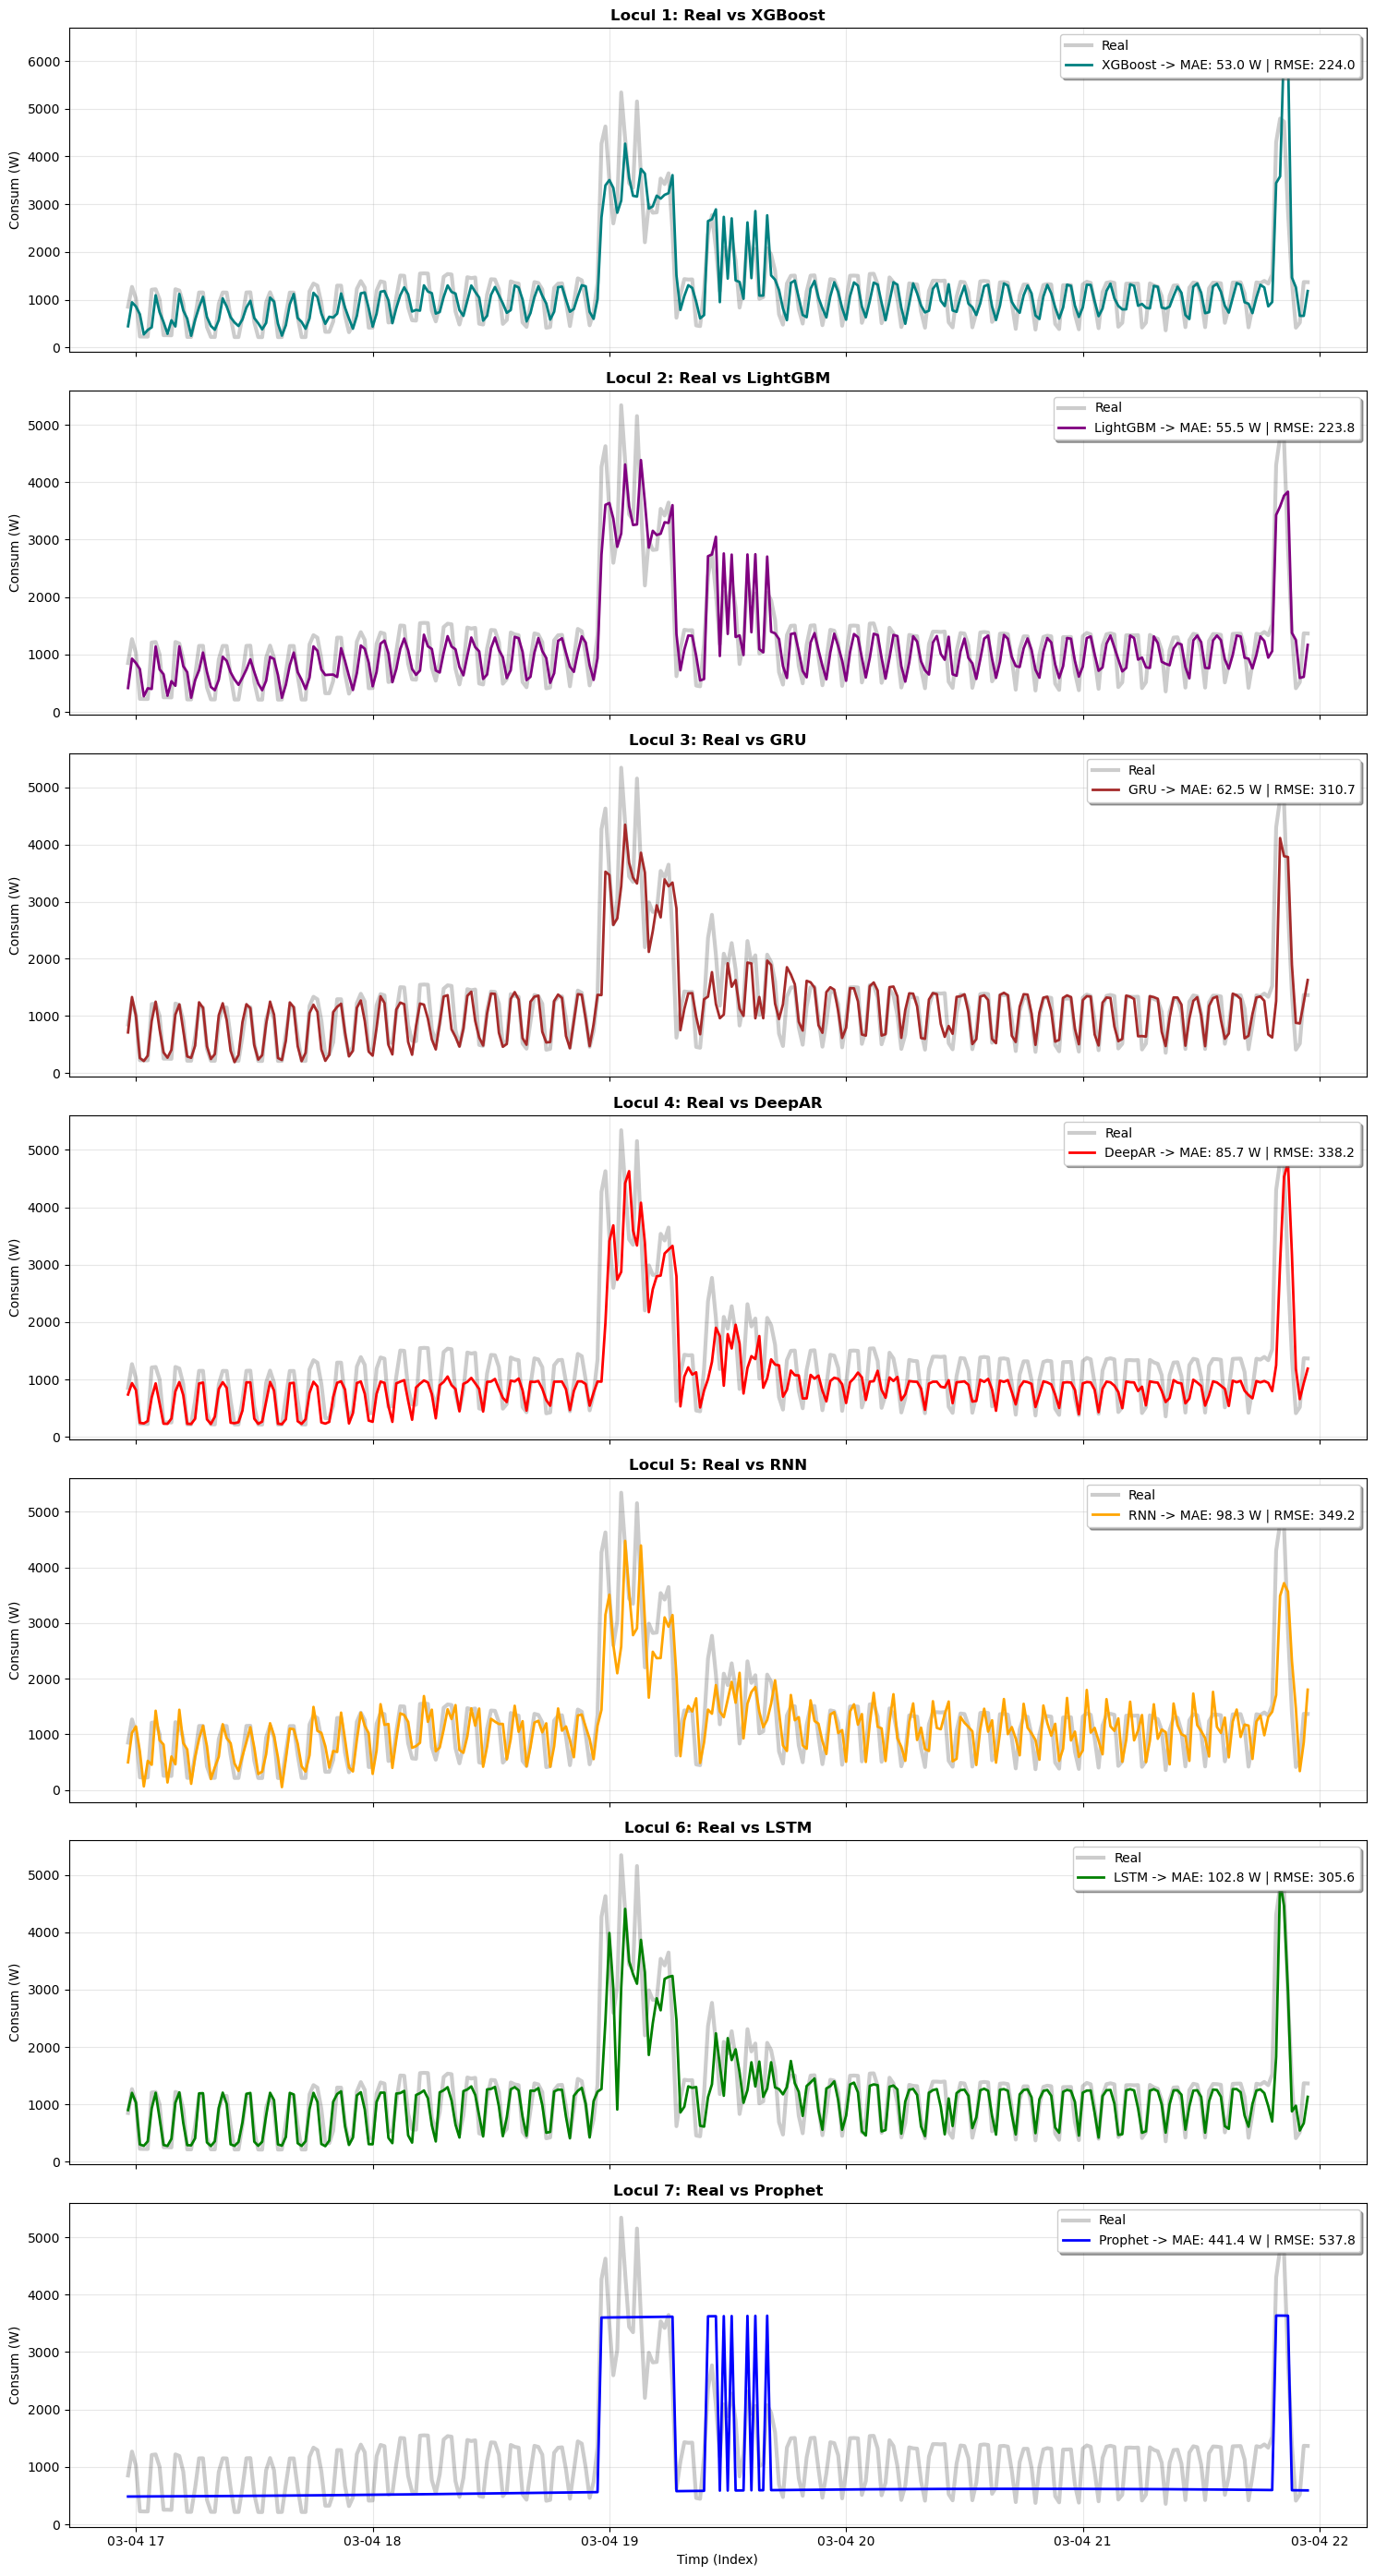

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 2. TABEL CLASAMENT (SORTAT DUPA MAE) ---
print("\n" + "="*60)
print("=== CLASAMENT FINAL (Sortat dupa MAE - Eroare Absoluta) ===")
print("="*60)
print(f"{'MODEL':<12} | {'MAE (W)':<10} | {'RMSE':<10} | {'TIMP (s)':<10}")
print("-" * 60)

# Lista pentru a stoca rezultatele si a le sorta
lista_metrici = []

for model_name, pred in rezultate_finale.items():
    # Ne asiguram ca lungimile sunt egale
    min_len = min(len(test_data), len(pred))
    y_true = test_data['Aggregate'].iloc[:min_len].values
    y_pred = pred[:min_len]
    
    # Calcul metrici
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    timp = timpi_antrenare.get(model_name, 0.0)
    
    # Adaugam in lista
    lista_metrici.append({
        'nume': model_name,
        'mae': mae,
        'rmse': rmse,
        'timp': timp,
        'pred': pred # Pastram predictia pt grafice mai jos
    })

# SORTEAZA lista dupa MAE (cel mai mic primul)
lista_metrici_sortata = sorted(lista_metrici, key=lambda x: x['mae'])

# Afisare tabel
for m in lista_metrici_sortata:
    print(f"{m['nume']:<12} | {m['mae']:<10.2f} | {m['rmse']:<10.2f} | {m['timp']:<10.1f}s")
print("-" * 60)


# --- 3A. GRAFIC COMPARATIV: TIMPI DE ANTRENARE ---
print("\nGenerare grafic timpi de antrenare...")

plt.figure(figsize=(10, 6))

# Extragem datele pentru graficul de timp (pastram ordinea din dictionarul original sau sortam, aici lasam originalul pt diversitate)
nume_modele_timp = list(timpi_antrenare.keys())
valori_timp = list(timpi_antrenare.values())

# Culori diverse pt bare
colors_bar = plt.cm.viridis(np.linspace(0, 0.8, len(nume_modele_timp)))

bars = plt.bar(nume_modele_timp, valori_timp, color=colors_bar)

# Adaugam text deasupra fiecarei bare
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.title('Comparatie Timpi de Antrenare (secunde)', fontsize=14)
plt.ylabel('Secunde')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# --- 3B. GRAFICE DETALIU: REAL vs PREDICTIE (CU METRICI) ---
print("\nGenerare grafice detaliate (Zoom)...")

# Setari afisare (Zoom pe primele X puncte din test)
ZOOM = 300  
test_zoom = test_data.index[:ZOOM]
val_real = test_data['Aggregate'].values[:ZOOM]

# Extindem paleta de culori pentru toate modelele
colors = {
    'Prophet': 'blue', 
    'LSTM': 'green', 
    'RNN': 'orange', 
    'GRU': 'brown',
    'DeepAR': 'red', 
    'XGBoost': 'teal',
    'LightGBM': 'purple'
}

# Cream subplot-urile (folosim lista sortata ca sa apara in ordinea performantei, sau dictionarul original)
# Aici iteram prin lista sortata ca sa vedem cel mai bun model primul
num_modele = len(lista_metrici_sortata)
fig, axes = plt.subplots(nrows=num_modele, ncols=1, figsize=(15, 4 * num_modele), sharex=True)

if num_modele == 1: axes = [axes] 

for i, m in enumerate(lista_metrici_sortata):
    ax = axes[i]
    nume = m['nume']
    pred = m['pred']
    mae_val = m['mae']
    rmse_val = m['rmse']
    
    # 1. Plotam Realitatea (Gri deschis)
    ax.plot(test_zoom, val_real, label='Real', color='black', alpha=0.2, linewidth=3)
    
    # 2. Plotam Predictia Modelului
    culoare = colors.get(nume, 'magenta') 
    
    # Afisam MAE si RMSE direct in legenda
    label_text = f'{nume} -> MAE: {mae_val:.1f} W | RMSE: {rmse_val:.1f}'
    
    ax.plot(test_zoom, pred[:ZOOM], label=label_text, color=culoare, linewidth=2)
    
    # 3. Estetica
    ax.set_title(f'Locul {i+1}: Real vs {nume}', fontweight='bold', fontsize=12)
    ax.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('Consum (W)')

plt.xlabel('Timp (Index)')
plt.tight_layout()
plt.show()